<a href="https://colab.research.google.com/github/Ashi743/ML-practices/blob/main/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit,
                                     KFold, StratifiedKFold,GroupKFold, StratifiedGroupKFold)
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

plt.style.use("seaborn-white")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
<ipython-input-1-c81f152e7572>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


In [9]:
df.nunique()

,0
id,5110
gender,3
age,104
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3979
bmi,418


In [10]:
hold_out_ids

Index([4688, 4478, 3849, 4355, 3826, 3951, 3396,  465,  410, 1632,
       ...
        414, 3935, 3398, 3309, 4700, 1197,  501,  437,  653, 2095],
      dtype='int64', length=500)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00
doctor,5110.0,4.007241,1.985893,1.00,2.000,4.000,6.00,7.00


In [8]:
df= pd.read_csv("/content/healthcare-dataset-stroke-data.csv")


df["gender"]= df["gender"].astype("category")
df["ever_married"]= df["ever_married"].astype("category")
df["work_type"]= df["work_type"].astype("category")

df["Residence_type"]= df["Residence_type"].astype("category")
df["smoking_status"]= df["smoking_status"].astype("category")

df["ever_married"]= df["ever_married"].map({"Yes":True,"No":False})


df["doctor"]= np.random.randint(low=1, high=8, size=len(df), dtype=int)
hold_out_ids= df.sample(500, random_state=42).index

train= df.loc[~df.index.isin(hold_out_ids)].sample(frac=1, random_state=529).sort_values("doctor").reset_index(drop=True) #drops holdoutindex set earlier
holdout= df.loc[df.index.isin(hold_out_ids)].sample(frac=1, random_state=529).sort_values("doctor").reset_index(drop=True)

In [14]:
holdout.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,72792,Female,53.0,1,0,True,Private,Rural,77.94,33.0,never smoked,0,1
1,42117,Male,43.0,0,0,True,Self-employed,Urban,143.43,45.9,Unknown,1,1
2,31692,Male,67.0,0,0,True,Private,Rural,83.16,28.3,never smoked,0,1
3,24836,Female,61.0,0,0,True,Private,Rural,72.01,26.0,formerly smoked,0,1
4,57549,Female,76.0,0,0,True,Self-employed,Urban,110.07,31.8,never smoked,0,1


In [77]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'doctor'],
      dtype='object')

In [15]:
def x_y_col(data):
  Features= ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']

  Groups= ["doctor"]
  Target= ["stroke"]

  x= data[Features]
  y= data[Target]
  groups= data[Groups]

  return x, y, groups

In [62]:
x_train, y_train, groups= x_y_col(train)
x_test, y_test, groups  = x_y_col(holdout)

In [63]:
model = lgb.LGBMClassifier(n_estimators=105)
model.fit(x_train, y_train)
y_pred= model.predict(x_train)
y_pred_proba= model.predict_proba(x_train)[:, 1]
print(accuracy_score(y_train, y_pred))
print(roc_auc_score(y_train, y_pred))
print(roc_auc_score(y_train, y_pred_proba))


[LightGBM] [Info] Number of positive: 221, number of negative: 4389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4610, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047939 -> initscore=-2.988694
[LightGBM] [Info] Start training from score -2.988694
0.9956616052060737
0.9568996534940807
0.999967009254935


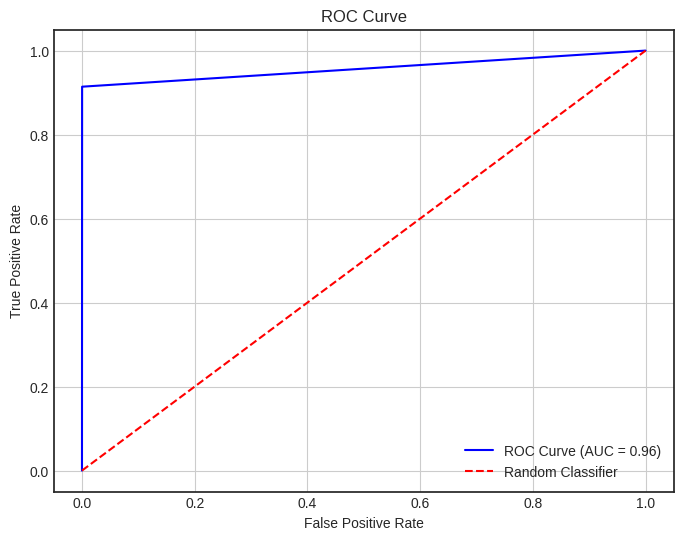

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)

def plot_roc_curve(fpr, tpr):
  # Plot the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

plot_roc_curve(fpr, tpr)


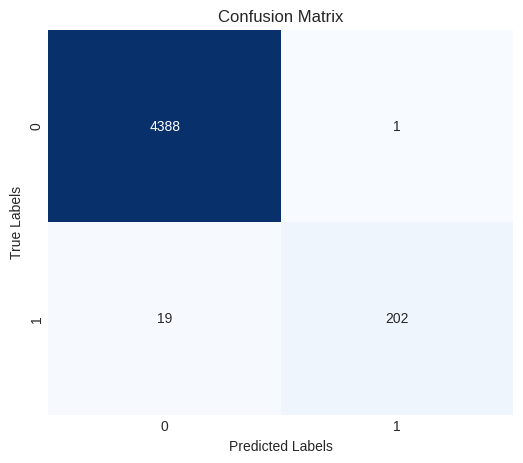

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
cm = confusion_matrix(y_train, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [76]:
from sklearn.model_selection import cross_val_score
from contextlib import redirect_stdout
import io

f = io.StringIO()

# Suppress LGBM output
with redirect_stdout(f):
  model = lgb.LGBMClassifier(n_estimators=105)
  model.fit(x_train, y_train)
  y_pred= model.predict(x_test)
  y_pred_proba= model.predict_proba(x_test)[:, 1]
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))
  # Clear the StringIO buffer
f.seek(0)
f.truncate(0)
print(cross_val_score(model, x_test, y_test, cv=5))

0.944
0.5335956416464891
0.7729267554479419
[LightGBM] [Info] Number of positive: 23, number of negative: 377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057500 -> initscore=-2.796751
[LightGBM] [Info] Start training from score -2.796751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

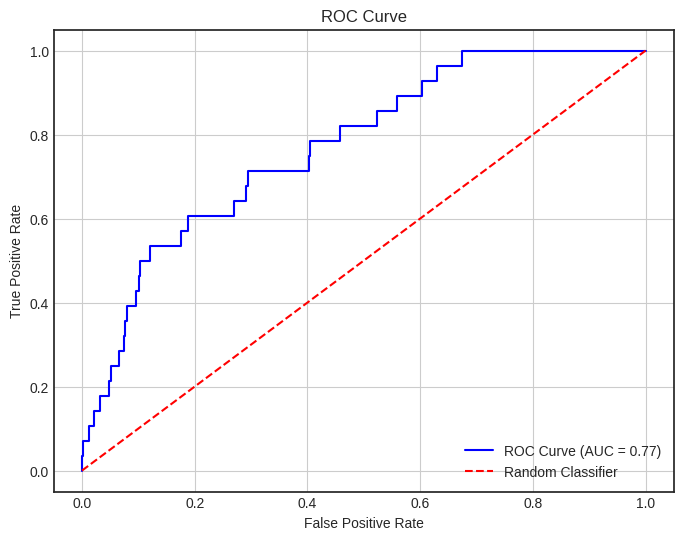

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plot_roc_curve(fpr, tpr)

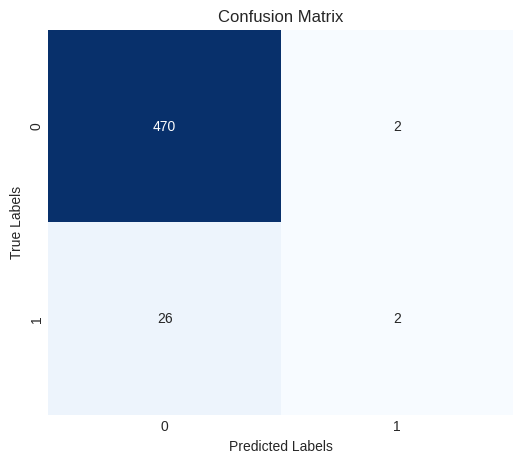

In [68]:
cm= confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Predicting all zeros ie no attack

In [23]:
acc_score= accuracy_score(y_test, np.zeros_like(y_test))
roc_auc= roc_auc_score(y_test, np.zeros_like(y_test))

print(f"baseline on testing set is {acc_score: 0.4f}, and AUC={roc_auc: 0.4f}")

baseline on testing set is  0.9440, and AUC= 0.5000


[LightGBM] [Info] Number of positive: 166, number of negative: 3522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3688, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045011 -> initscore=-3.054797
[LightGBM] [Info] Start training from score -3.054797
0.9425162689804772
0.8187899758834016


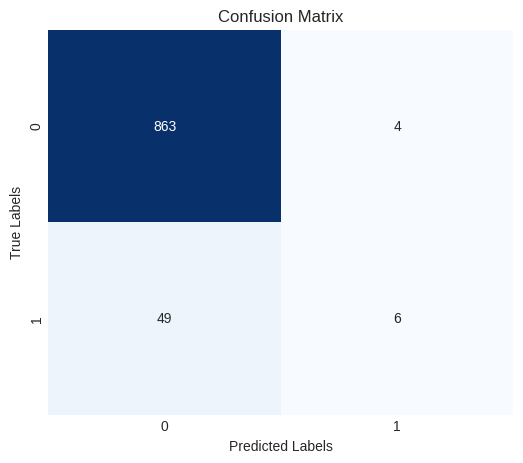

In [25]:
x,y,group= x_y_col(train)

x_train, x_val, y_train, y_val= train_test_split(x,y, test_size=0.2, random_state=42)
clf= lgb.LGBMClassifier(n_estimators=100)
clf.fit(x_train, y_train)
y_pred= clf.predict(x_val)
y_prd_proba= clf.predict_proba(x_val)[:, 1]
print(accuracy_score(y_val, y_pred))
print(roc_auc_score(y_val, y_prd_proba))

cm= confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
'''https://scikit-learn.org/stable/auto_examples/model_selection/
      plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py'''

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

In [52]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [53]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [54]:
def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()

In [55]:
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

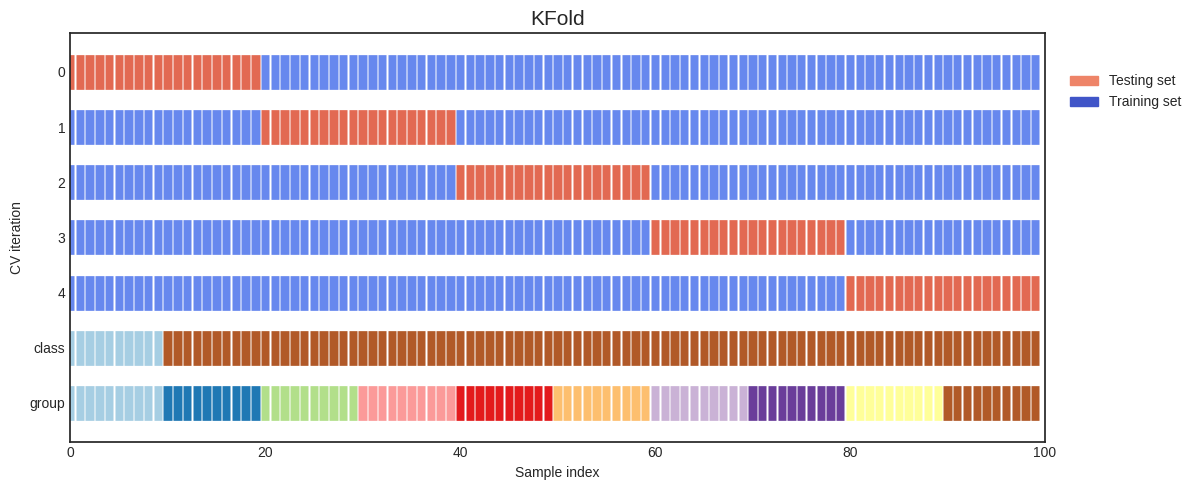

In [56]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

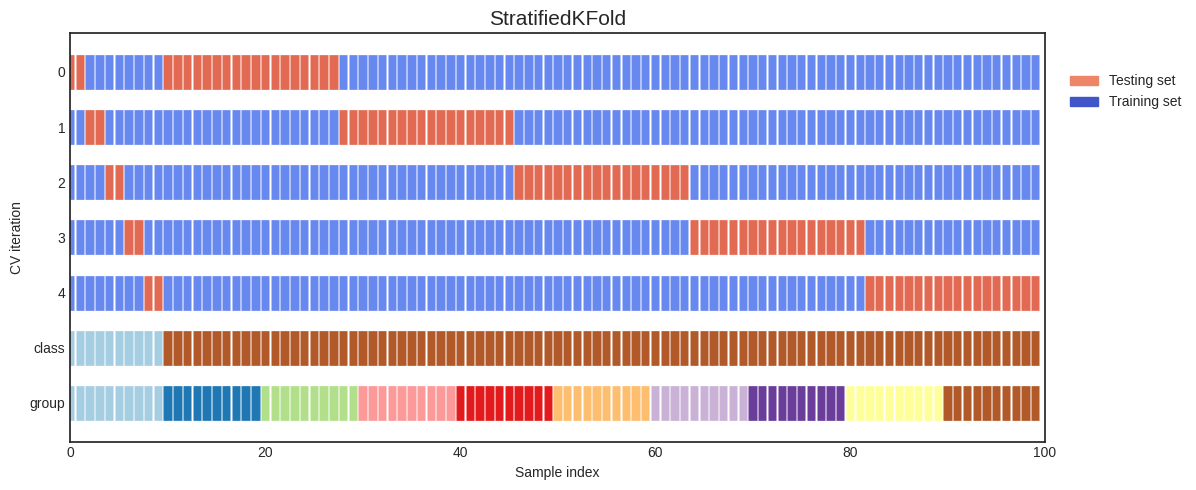

In [40]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

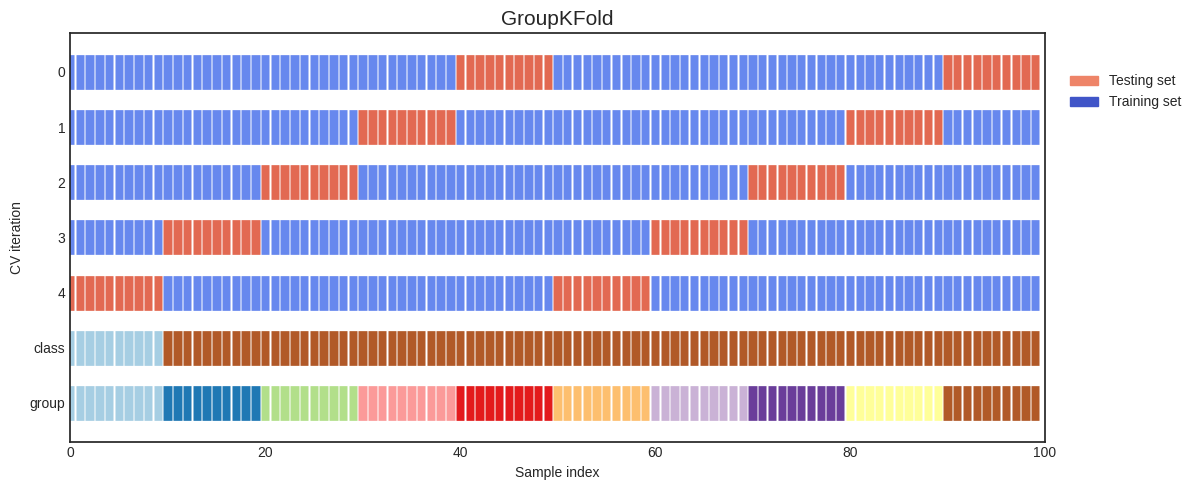

In [41]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

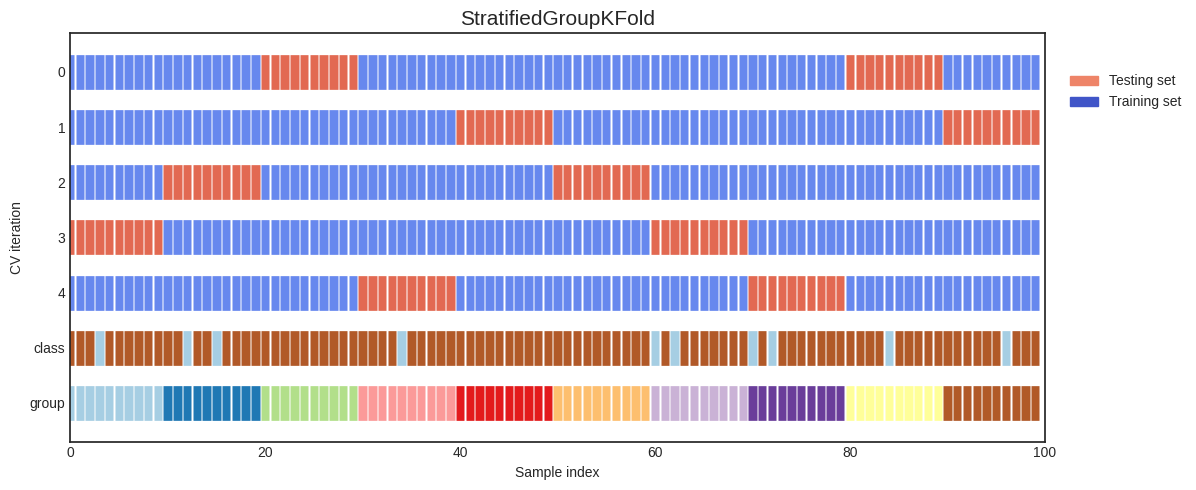

In [42]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

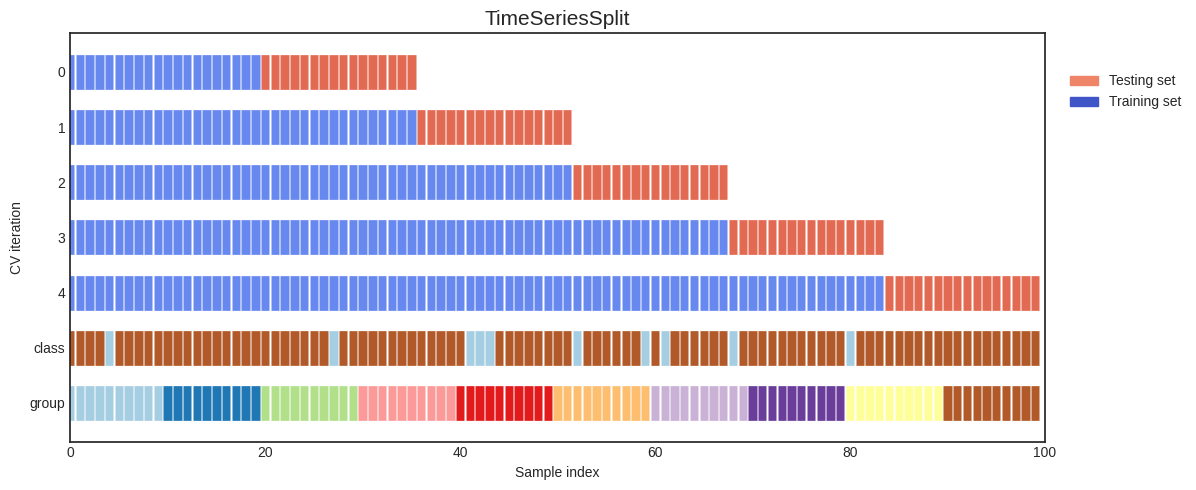

In [43]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

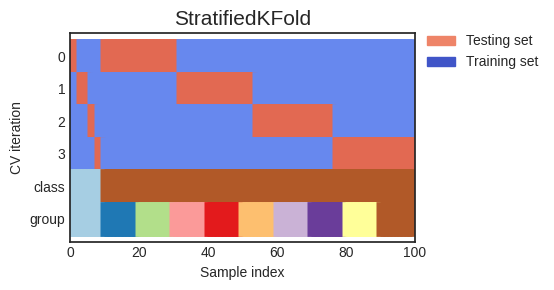

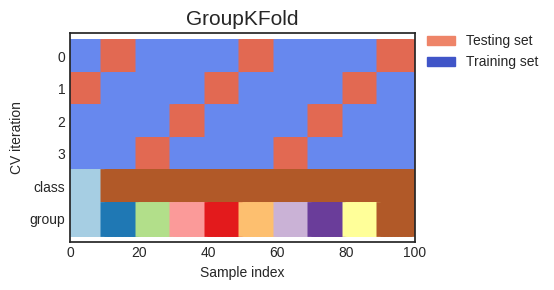

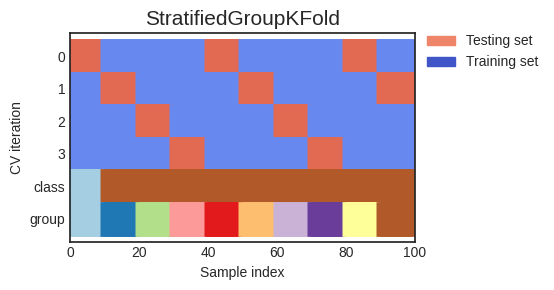

In [58]:
cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X_, y_, groups_, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

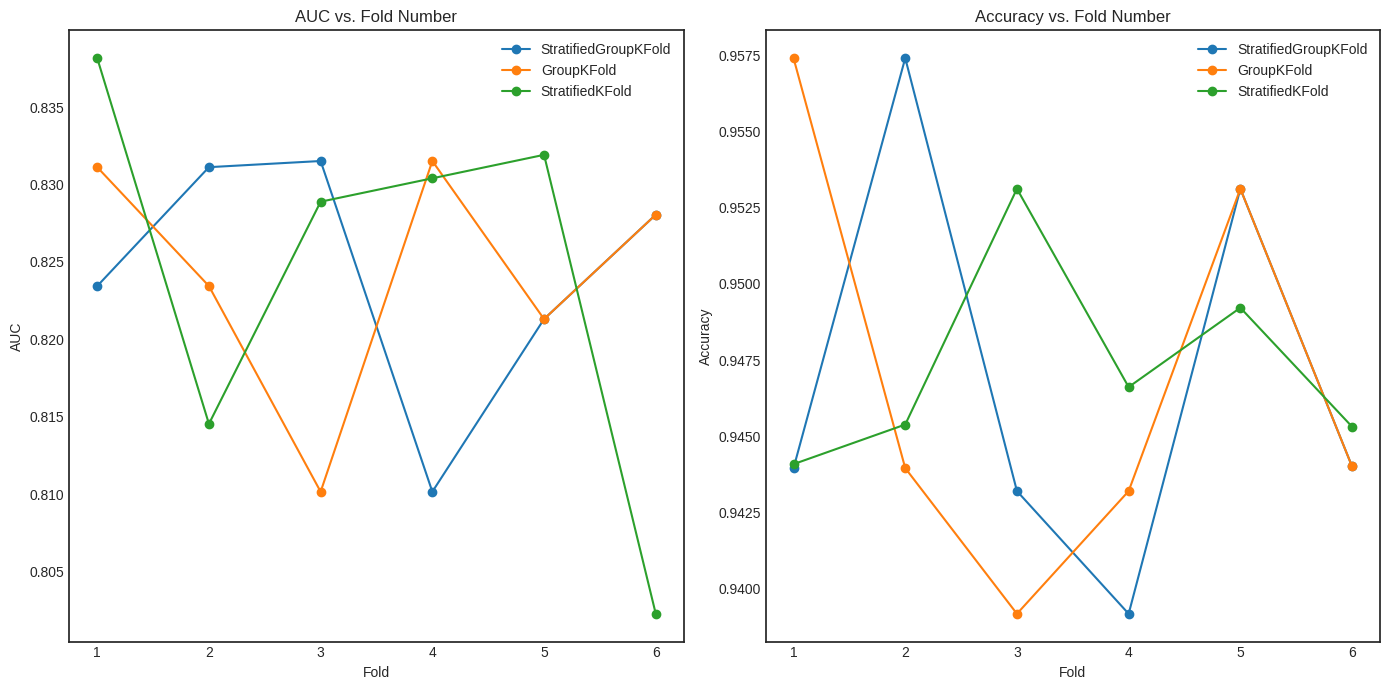

In [61]:
x,y,groups= x_y_col(train)
# Initialize cross-validation strategies
v=6
sgkf = StratifiedGroupKFold(n_splits=v, shuffle=True, random_state=42)
gkf = GroupKFold(n_splits=v)
skf = StratifiedKFold(n_splits=v)

cv_strategies = [sgkf, gkf, skf]
cv_names = ['StratifiedGroupKFold', 'GroupKFold', 'StratifiedKFold']

# To store results
results = {name: {'folds': [], 'auc': [], 'acc': []} for name in cv_names}


from contextlib import redirect_stdout
import io

f = io.StringIO()



# Perform cross-validation
for cv, name in zip(cv_strategies, cv_names):
    for fold, (train_index, test_index) in enumerate(cv.split(x, y, groups)):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Suppress LGBM output
        with redirect_stdout(f):
          clf = lgb.LGBMClassifier(n_estimators=100)
          clf.fit(X_train, y_train)
          y_pred = clf.predict(X_test)
          y_pred_proba = clf.predict_proba(X_test)[:, 1]
          acc_score = accuracy_score(y_test, y_pred)
          auc_score = roc_auc_score(y_test, y_pred_proba)

          results[name]['folds'].append(fold + 1)  # Fold numbers start from 1
          results[name]['auc'].append(auc_score)
          results[name]['acc'].append(acc_score)

          # Clear the StringIO buffer
          f.seek(0)
          f.truncate(0)

# Plot results
plt.figure(figsize=(14, 7))

# Plot AUC
plt.subplot(1, 2, 1)
for name in cv_names:
    plt.plot(results[name]['folds'], results[name]['auc'], marker='o', label=name)
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.title('AUC vs. Fold Number')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
for name in cv_names:
    plt.plot(results[name]['folds'], results[name]['acc'], marker='o', label=name)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Fold Number')
plt.legend()

plt.tight_layout()
plt.show()